# PHYS 650 Homework 2
Data for this assignment are available in this folder. 

---
### 1) From the radiosonde file provided, generate a SKew-T plot/diagram. You can use this available, Python resource: https://unidata.github.io/MetPy/latest/api/generated/metpy.plots.SkewT.html

In [226]:
from metpy.calc import mixing_ratio_from_relative_humidity as mixing_ratio
from metpy.calc import vapor_pressure as vapor_pressure
from metpy.calc import potential_temperature as Theta
from metpy.calc import dewpoint as dewpoint

import matplotlib.pyplot as plt
from metpy.units import units
import metpy.plots as plots
import pandas as pd
import numpy as np
import copy as cp

%matplotlib inline

Importing the data from the file (HUBV_RS41GP_20220316.txt) was a little tricky. There are some very important things to consider when importing this dataset. Be sure to ACTUALLY look through the file first. 
Note that...
- The entire file is double spaced!
- The file has few sections separated by blank space
- The data we will use is from lines 18 - 13509

In [2]:
df = pd.read_csv(r"HUBV_RS41GP_20220316.txt", 
                 skiprows=14,           # Lets skip the intro and go straigh to line 15 
                 header=0,              # The first line read is the column names (headers) 
                 sep="\s+",             # The columns are seperated (sep) by spaces that vary in size (\s+)
                 nrows=6746)            # Look in the file to understand this one: (13509 - 17) / 2 = 6476

df.columns

Index(['Time', 'Height', 'Pressure', 'Temp', 'Humidity', 'WDir', 'WSpeed',
       'Lat', 'Lon'],
      dtype='object')

In [3]:
df.head()

,Time,Height,Pressure,Temp,Humidity,WDir,WSpeed,Lat,Lon
0,0.0,52,1014.9,22.9,26.7,96.0,2.1,39.0563,-76.8755
1,1.3,57,1014.4,21.9,28.9,117.4,2.3,39.0563,-76.8757
2,2.3,63,1013.7,21.3,28.5,119.8,2.6,39.0563,-76.8757
3,3.3,70,1012.9,21.1,29.0,119.8,2.8,39.0563,-76.8757
4,4.3,78,1012.0,20.8,29.3,119.1,3.1,39.0563,-76.8757


To make sure that the data was imported correctly, just check the last entry with the file. Tis the beauty of text... 

In [4]:
df.iloc[-1]

Time         6747.3000
Height      14748.0000
Pressure      128.1000
Temp          -62.0000
Humidity        2.4000
WDir          261.2000
WSpeed         15.6000
Lat            39.2140
Lon           -75.5889
Name: 6745, dtype: float64

In [258]:
temp = (np.array(df.Temp) * units.degC).to(units.K)
rh = (np.array(df.Humidity) / 100.)
press = (np.array(df.Pressure) * units.hPa)
vp = vapor_pressure(press, np.array(df.MixingRatio))
dp = dewpoint(vp)

df["Theta"] = Theta(press, temp)
df["MixingRatio"] = mixing_ratio(press, temp, rh)
df["VaporPressure"] = vp
df["Dewpoint"] = dp
df["q"] = Theta(press, dp)
df["N"] = [((77.6 * (df.Pressure[i] / (df.Temp[i] + 273.15))) + ((3.72 * 10**5) * (df.VaporPressure[i] / ((df.Temp[i] + 273.15)**2)))) for i in np.arange(0, len(df))]

In [259]:
df.head()

,Time,Height,Pressure,Temp,Humidity,WDir,WSpeed,Lat,Lon,Dewpoint,LapseRate,Theta,q,MixingRatio,VaporPressure,N
0,0.0,52,1014.9,22.9,26.7,96.0,2.1,39.0563,-76.8755,3.052836,-0.005777,294.801610,275.038137,0.004697,7.606821,298.309573
1,1.3,57,1014.4,21.9,28.9,117.4,2.3,39.0563,-76.8757,3.286699,-0.200000,293.847196,275.309774,0.004778,7.733663,299.840935
2,2.3,63,1013.7,21.3,28.5,119.8,2.6,39.0563,-76.8757,2.563616,-0.100000,293.307485,274.643801,0.004541,7.347419,298.677692
3,3.3,70,1012.9,21.1,29.0,119.8,2.8,39.0563,-76.8757,2.630852,-0.028571,293.174385,274.772750,0.004566,7.382599,298.842315
4,4.3,78,1012.0,20.8,29.3,119.1,3.1,39.0563,-76.8757,2.510522,-0.037500,292.949876,274.722625,0.004531,7.319744,298.671515


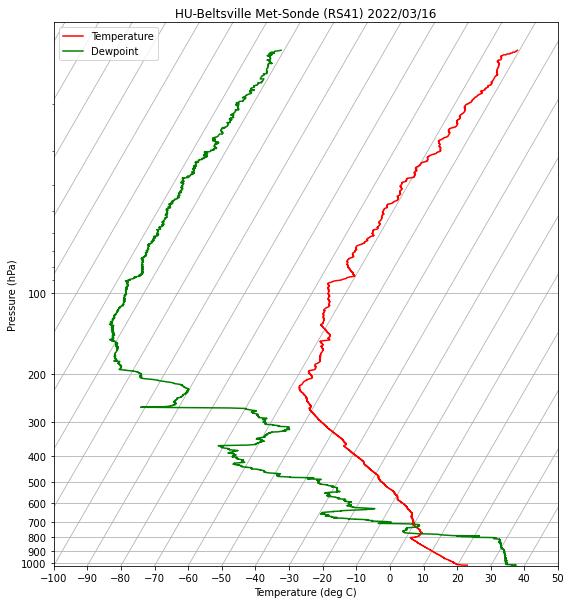

In [74]:
fig = plt.figure(figsize=(10, 10))
skew = plots.SkewT(fig)

# Sometimes sonde data is still transmitted on the decent. by slicing with "0:df.Height.idxmax()" we are only use data upto the max hiehgt.
skew.plot(df.Pressure[0:df.Height.idxmax()], df.Temp[0:df.Height.idxmax()], "red", label="Temperature") 
skew.plot(df.Pressure[0:df.Height.idxmax()], df.Dewpoint[0:df.Height.idxmax()], "green", label="Dewpoint")

skew.ax.set_ylim(1020, 10)
skew.ax.set_xlim(-100, 50)

skew.ax.set_ylabel("Pressure (hPa)")
skew.ax.set_xlabel("Temperature (deg C)")

skew.ax.legend()
skew.ax.set_title("HU-Beltsville Met-Sonde (RS41) 2022/03/16")
plt.show()

Plotted here is the Temprerauter profile measured by the Vaisala RS41 Met-Sonde launched from Howard University Beltsville Campus on 03/16/2022. 

The figure shows an temperature inversion at the 800hPa pressure level. Clouds are most likely located between 800 hPa - 700 hPa. 

---
### 2) Determine the Environmental Lapse Rate (Γe = - ΔT/Δz) for this sounding?

In [98]:
df.loc[df.Pressure <= 1000] # (idx, pressure, height) (26, 999.6, 183)
df.loc[df.Height >= 1183] # (idx, pressure, height) (187, 887.5, 1185)

,Time,Height,Pressure,Temp,Humidity,WDir,WSpeed,Lat,Lon,Dewpoint,LapseRate
187,187.3,1185,887.5,9.0,51.1,149.6,4.8,39.0609,-76.8840,30.971437,-0.016667
188,188.3,1192,886.8,8.9,51.1,149.7,4.8,39.0609,-76.8840,30.804822,-0.014286
189,189.3,1199,886.1,8.9,51.0,149.8,4.8,39.0609,-76.8841,30.756503,0.000000
190,190.3,1205,885.4,8.8,51.1,150.0,4.8,39.0609,-76.8841,30.638202,-0.016667
191,191.3,1212,884.7,8.7,51.4,150.1,4.8,39.0610,-76.8841,30.615813,-0.014286
...,...,...,...,...,...,...,...,...,...,...,...
6741,6743.3,14786,127.3,-62.2,2.5,262.0,17.9,39.2138,-75.5903,-123.861613,-0.000000
6742,6744.3,14776,127.5,-62.1,2.4,261.8,17.3,39.2138,-75.5900,-124.147039,-0.010000
6743,6745.3,14767,127.7,-62.1,2.4,261.6,16.7,39.2139,-75.5896,-124.147039,-0.000000
6744,6746.3,14757,127.9,-62.0,2.4,261.4,16.2,39.2140,-75.5892,-124.012642,-0.010000


In [99]:
Temp = np.array([df.Temp.iloc[187], df.Temp.iloc[26]])
L = (Temp[1] - Temp[0]); print(-round(L, 2))
adL1 = (-10)

-10.1


The the Environmental Lapse rate is ~ 10.1 C/Km. 

---
### 3) Given that the Dry and Moist Adiabatic Lapse Rate are 10°C/1km and 6 °C/1km, respectively, how would you categorize the static stability of the atmosphere at the time of the sounding?

In [137]:
alt = np.arange(0, 11, 1)
eL = [df.Temp.iloc[0]]
dL = [df.Temp.iloc[0]]
mL = [df.Temp.iloc[0]]
for i in alt[1::]:
    eL.append(eL[i-1] + (-L))
    dL.append(adL[i-1] + (-10))
    mL.append(mL[i-1] + (-6))

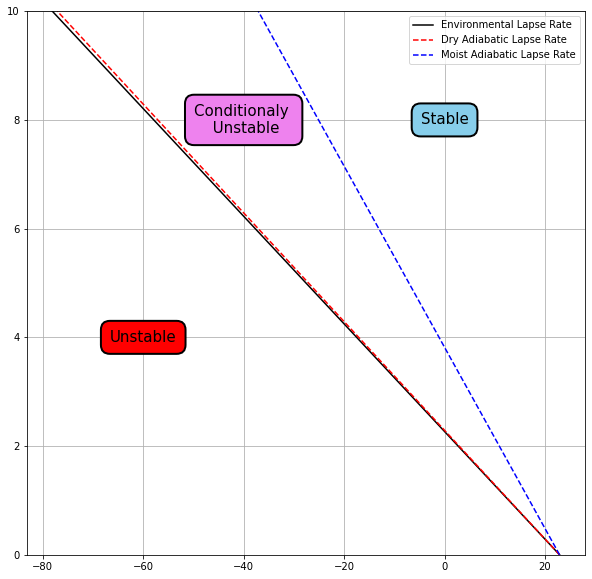

In [172]:
plt.figure(figsize=(10, 10))
plt.plot(eL, alt, "k", label="Environmental Lapse Rate")
plt.plot(dL, alt, "r--", label="Dry Adiabatic Lapse Rate")
plt.plot(mL, alt, "b--", label="Moist Adiabatic Lapse Rate")
plt.grid(True)
plt.ylim(0, 10)
plt.legend()

# Unstable
t = plt.text(
    -60, 4, "Unstable", ha="center", va="center", size=15,
    bbox=dict(boxstyle="rarrow,pad=0.3", fc="red", ec="k", lw=2))

bb = t.get_bbox_patch()
bb.set_boxstyle("round", pad=0.6)

# Conditionaly Unstable
t = plt.text(
    -40, 8, "Conditionaly \n Unstable", ha="center", va="center", size=15,
    bbox=dict(boxstyle="rarrow,pad=0.3", fc="violet", ec="k", lw=2))

bb = t.get_bbox_patch()
bb.set_boxstyle("round", pad=0.6)

# Stable
t = plt.text(
    0, 8, "Stable", ha="center", va="center", size=15,
    bbox=dict(boxstyle="rarrow,pad=0.3", fc="skyblue", ec="k", lw=2))

bb = t.get_bbox_patch()
bb.set_boxstyle("round", pad=0.6)

plt.show()

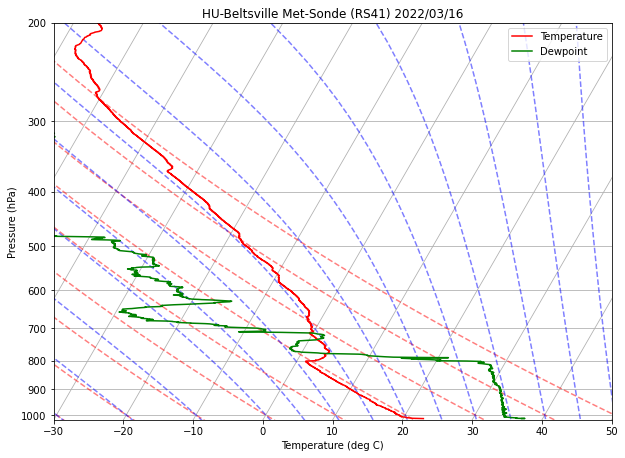

In [117]:
fig = plt.figure(figsize=(10, 10))
skew = plots.SkewT(fig)

# Sometimes sonde data is still transmitted on the decent. by slicing with "0:df.Height.idxmax()" we are only use data upto the max hiehgt.
skew.plot(df.Pressure[0:df.Height.idxmax()], df.Temp[0:df.Height.idxmax()], "red", label="Temperature")
skew.plot(df.Pressure[0:df.Height.idxmax()], df.Dewpoint[0:df.Height.idxmax()], "green", label="Dewpoint")

skew.plot_dry_adiabats()
skew.plot_moist_adiabats
()

skew.ax.set_ylim(1020, 200)
skew.ax.set_xlim(-30, 50)

skew.ax.set_ylabel("Pressure (hPa)")
skew.ax.set_xlabel("Temperature (deg C)")

skew.ax.legend()
skew.ax.set_title("HU-Beltsville Met-Sonde (RS41) 2022/03/16")
plt.show()

This shows that the enviromenta is Neutral or Conditionaly Unstable as it follows closely with the dry adiabatic line.

---
### 4) What is the planetary boundary layer height for this sounding? Follow the analysis by Wang et al. (2014): Atmos. Meas. Tech., 7, 1701–1709

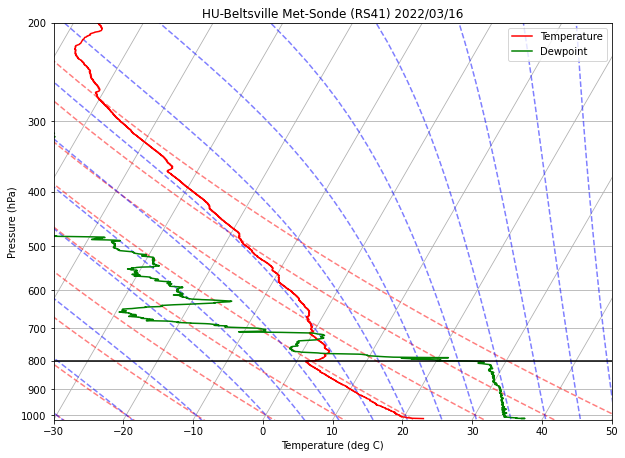

In [176]:
fig = plt.figure(figsize=(10, 10))
skew = plots.SkewT(fig)

# Sometimes sonde data is still transmitted on the decent. by slicing with "0:df.Height.idxmax()" we are only use data upto the max hiehgt.
skew.plot(df.Pressure[0:df.Height.idxmax()], df.Temp[0:df.Height.idxmax()], "red", label="Temperature")
skew.plot(df.Pressure[0:df.Height.idxmax()], df.Dewpoint[0:df.Height.idxmax()], "green", label="Dewpoint")

skew.plot_dry_adiabats()
skew.plot_moist_adiabats()

skew.ax.set_ylim(1020, 200)
skew.ax.set_xlim(-30, 50)

skew.ax.set_ylabel("Pressure (hPa)")
skew.ax.set_xlabel("Temperature (deg C)")

skew.ax.axhline(800*units.hPa, color="k")

skew.ax.legend()
skew.ax.set_title("HU-Beltsville Met-Sonde (RS41) 2022/03/16")
plt.show()

The temperature Inversion at 800 hPa indicates the height of mixing layer. 

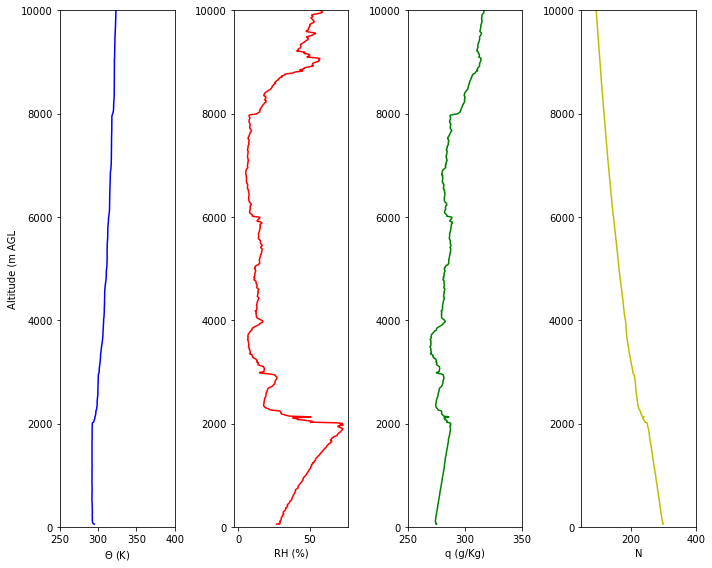

In [271]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(10, 8))

ax[0].plot(df["Theta"][0:df.Height.idxmax()], df["Height"][0:df.Height.idxmax()], "b")
ax[0].set_ylim(0, 10000)
ax[0].set_xlim(250, 400)
ax[0].set_xlabel("$\Theta$ (K)")
ax[0].set_ylabel("Altitude (m AGL")

ax[1].plot(df["Humidity"][0:df.Height.idxmax()], df["Height"][0:df.Height.idxmax()], "r")
ax[1].set_ylim(0, 10000)
ax[1].set_xlabel("RH (%)")

ax[2].plot(df["q"][0:df.Height.idxmax()], df["Height"][0:df.Height.idxmax()], "g")
ax[2].set_ylim(0, 10000)
ax[2].set_xlim(250, 350)
ax[2].set_xlabel("q (g/Kg)")

ax[3].plot(df["N"][0:df.Height.idxmax()], df["Height"][0:df.Height.idxmax()], "y")
ax[3].set_ylim(0, 10000)
ax[3].set_xlim(50, 400)
ax[3].set_xlabel("N")

plt.tight_layout()


plt.show()